In [1]:
# https://medium.com/@HeeebsInc/using-machine-learning-to-predict-daily-fantasy-basketball-scores-part-i-811de3c54a98

# https://medium.com/fun-with-data-and-stats/drafting-a-fantasy-basketball-team-c94967464908

In [2]:
# needed libraries
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd

# URL to scrape
url = "https://www.basketball-reference.com/playoffs/"

# collect HTML data
html = urlopen(url)
        
# create beautiful soup object from HTML
soup = BeautifulSoup(html, features="lxml")

# use getText()to extract the headers into a list
headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]

# get rows from table
rows = soup.findAll('tr')[2:]
rows_data = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

# if you print row_data here you'll see an empty row
# so, remove the empty row
rows_data.pop(20)
# for simplicity subset the data for only 39 seasons
rows_data = rows_data[0:38]

# we're missing a column for years
# add the years into rows_data
last_year = 2020
for i in range(0, len(rows_data)):
    rows_data[i].insert(0, last_year)
    last_year -=1
    
# create the dataframe
nba_finals = pd.DataFrame(rows_data, columns = headers)
# export dataframe to a CSV 
nba_finals.to_csv("nba_finals_history.csv", index=False)

# Web Scraper

In [3]:
# https://github.com/klaudius1D/ShootersShoot/tree/main

In [4]:
import pandas as pd
import requests
import os
from bs4 import BeautifulSoup

# settings
pd.set_option('display.max_columns', None)

In [5]:
# Set Playoff Years from 2020 to 2023
years = list(range(2020, 2024))

# {} used to vary dates in loop
url_start = "https://www.basketball-reference.com/playoffs/NBA_{}_per_game.html"

# Replace brackets with specific years based on list
for year in years:
    url = url_start.format(year)
    data = requests.get(url)

    # Create HTML files for each year
    with open("topPicksHTML/Playoffs-{}_topPicks.html".format(year), "wb") as f:
        f.write(data.content)

In [6]:
# using a loop, parse each html for each year in years list
dfs = []
for year in years:
    url = url_start.format(year)
    data = requests.get(url)
    soup = BeautifulSoup(data.content, "html.parser")
    topPicks_table = soup.find("table", {"id": "per_game_stats"})
    topPicks_df = pd.read_html(str(topPicks_table))[0]
    topPicks_df = topPicks_df[topPicks_df.Rk != "Rk"]
    topPicks_df["Year"] = year

    dfs.append(topPicks_df)

    # Save all contents into one csv files into new folder called topPicksCSV
    topPicks_df.to_csv("topPicksCSV/Playoffs-{}_topPicks.csv".format(year), index=False)

In [7]:
# combine all dataframes into one
df = pd.concat(dfs)
df.to_csv("topPicksCSV/Playoffs-Master_topPicks.csv", index=False)

In [8]:
# check contents of dataframe, ensure all years are included
df.head()
df.tail()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
222,213,Ziaire Williams,SF,21,MEM,4,0,3.0,0.5,1.8,.286,0.3,0.8,.333,0.3,1.0,.250,.357,0.0,0.0,NaN,0.0,0.5,0.5,0.5,0.0,0.0,0.5,0.3,1.3,2023
223,214,Trae Young,PG,24,ATL,6,6,38.3,10.0,24.8,.403,3.0,9.0,.333,7.0,15.8,.442,.463,6.2,7.2,.860,0.8,2.8,3.7,10.2,1.7,0.7,4.0,1.8,29.2,2023
224,215,Omer Yurtseven,C,24,MIA,8,0,2.0,0.3,0.9,.286,0.0,0.3,.000,0.3,0.6,.400,.286,0.0,0.0,NaN,0.4,0.3,0.6,0.1,0.0,0.1,0.1,0.3,0.5,2023
225,216,Cody Zeller,C,30,MIA,21,0,8.3,1.0,1.7,.571,0.0,0.0,NaN,1.0,1.7,.571,.571,0.3,0.7,.400,0.5,1.8,2.3,0.3,0.1,0.2,0.6,1.3,2.2,2023
226,217,Ivica Zubac,C,25,LAC,5,5,26.0,3.4,6.0,.567,0.0,0.0,NaN,3.4,6.0,.567,.567,2.4,3.2,.750,3.2,6.4,9.6,0.6,0.6,0.2,2.2,1.6,9.2,2023


# Testing

In [9]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,1,Jaylen Adams,PG,23,POR,3,0,7.0,1.0,3.0,.333,0.0,1.3,.000,1.0,1.7,.600,.333,0.0,0.0,NaN,0.3,0.7,1.0,0.7,0.3,0.0,0.0,0.3,2.0,2020
1,2,Steven Adams,C,26,OKC,7,7,30.0,4.4,7.4,.596,0.0,0.1,.000,4.4,7.3,.608,.596,1.3,2.9,.450,4.9,6.7,11.6,1.3,0.6,0.3,2.3,1.4,10.1,2020
2,3,Bam Adebayo,PF,22,MIA,19,19,36.2,6.5,11.6,.564,0.0,0.1,.000,6.5,11.5,.566,.564,4.7,6.1,.783,2.5,7.8,10.3,4.4,1.0,0.8,2.5,3.1,17.8,2020
3,4,Jarrett Allen,C,21,BRK,4,4,33.0,3.5,6.0,.583,0.0,0.0,NaN,3.5,6.0,.583,.583,3.3,4.0,.813,4.3,10.5,14.8,2.3,0.5,1.8,2.8,1.8,10.3,2020
4,5,Justin Anderson,SG,26,BRK,3,0,9.3,1.7,4.0,.417,1.7,3.7,.455,0.0,0.3,.000,.625,1.3,1.3,1.000,0.0,2.7,2.7,1.0,0.0,0.3,0.7,0.7,6.3,2020


In [10]:
df.info()

# NEED TO CONVERT THESE COLUMNS TO INT

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 226
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rk      890 non-null    object
 1   Player  890 non-null    object
 2   Pos     890 non-null    object
 3   Age     890 non-null    object
 4   Tm      890 non-null    object
 5   G       890 non-null    object
 6   GS      890 non-null    object
 7   MP      890 non-null    object
 8   FG      890 non-null    object
 9   FGA     890 non-null    object
 10  FG%     851 non-null    object
 11  3P      890 non-null    object
 12  3PA     890 non-null    object
 13  3P%     746 non-null    object
 14  2P      890 non-null    object
 15  2PA     890 non-null    object
 16  2P%     822 non-null    object
 17  eFG%    851 non-null    object
 18  FT      890 non-null    object
 19  FTA     890 non-null    object
 20  FT%     695 non-null    object
 21  ORB     890 non-null    object
 22  DRB     890 non-null    ob

In [11]:
for column in df.columns:
    try:
        df[column] = pd.to_numeric(df[column], errors='raise').fillna(0).astype(float)
    except (ValueError, TypeError):
        pass  # Ignore columns that cannot be converted

In [12]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,1.0,Jaylen Adams,PG,23.0,POR,3.0,0.0,7.0,1.0,3.0,0.333,0.0,1.3,0.000,1.0,1.7,0.600,0.333,0.0,0.0,0.000,0.3,0.7,1.0,0.7,0.3,0.0,0.0,0.3,2.0,2020.0
1,2.0,Steven Adams,C,26.0,OKC,7.0,7.0,30.0,4.4,7.4,0.596,0.0,0.1,0.000,4.4,7.3,0.608,0.596,1.3,2.9,0.450,4.9,6.7,11.6,1.3,0.6,0.3,2.3,1.4,10.1,2020.0
2,3.0,Bam Adebayo,PF,22.0,MIA,19.0,19.0,36.2,6.5,11.6,0.564,0.0,0.1,0.000,6.5,11.5,0.566,0.564,4.7,6.1,0.783,2.5,7.8,10.3,4.4,1.0,0.8,2.5,3.1,17.8,2020.0
3,4.0,Jarrett Allen,C,21.0,BRK,4.0,4.0,33.0,3.5,6.0,0.583,0.0,0.0,0.000,3.5,6.0,0.583,0.583,3.3,4.0,0.813,4.3,10.5,14.8,2.3,0.5,1.8,2.8,1.8,10.3,2020.0
4,5.0,Justin Anderson,SG,26.0,BRK,3.0,0.0,9.3,1.7,4.0,0.417,1.7,3.7,0.455,0.0,0.3,0.000,0.625,1.3,1.3,1.000,0.0,2.7,2.7,1.0,0.0,0.3,0.7,0.7,6.3,2020.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 226
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rk      890 non-null    float64
 1   Player  890 non-null    object 
 2   Pos     890 non-null    object 
 3   Age     890 non-null    float64
 4   Tm      890 non-null    object 
 5   G       890 non-null    float64
 6   GS      890 non-null    float64
 7   MP      890 non-null    float64
 8   FG      890 non-null    float64
 9   FGA     890 non-null    float64
 10  FG%     890 non-null    float64
 11  3P      890 non-null    float64
 12  3PA     890 non-null    float64
 13  3P%     890 non-null    float64
 14  2P      890 non-null    float64
 15  2PA     890 non-null    float64
 16  2P%     890 non-null    float64
 17  eFG%    890 non-null    float64
 18  FT      890 non-null    float64
 19  FTA     890 non-null    float64
 20  FT%     890 non-null    float64
 21  ORB     890 non-null    float64
 22  DR

In [14]:
clean_fantasy = [
    "Player", 
    "MP", 
    "FG%",
    "FT%",
    "3P",
    "PTS",
    "TRB", 
    "AST",
    "STL",
    "BLK",
    "TOV",

]

In [15]:
per_30_stats = df[clean_fantasy]

In [16]:
per_30_stats[["PTS", "TRB", "AST", "STL", "BLK", "TOV"]] = df[["PTS", "TRB", "AST", "STL", "BLK", "TOV"]].div(df['MP'], axis = 0).multiply(30)

C:\Users\nehcr\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [17]:
per_30_stats.head()

,Player,MP,FG%,FT%,3P,PTS,TRB,AST,STL,BLK,TOV
0,Jaylen Adams,7.0,0.333,0.000,0.0,8.571429,4.285714,3.000000,1.285714,0.000000,0.000000
1,Steven Adams,30.0,0.596,0.450,0.0,10.100000,11.600000,1.300000,0.600000,0.300000,2.300000
2,Bam Adebayo,36.2,0.564,0.783,0.0,14.751381,8.535912,3.646409,0.828729,0.662983,2.071823
3,Jarrett Allen,33.0,0.583,0.813,0.0,9.363636,13.454545,2.090909,0.454545,1.636364,2.545455
4,Justin Anderson,9.3,0.417,1.000,1.7,20.322581,8.709677,3.225806,0.000000,0.967742,2.258065


In [18]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,1.0,Jaylen Adams,PG,23.0,POR,3.0,0.0,7.0,1.0,3.0,0.333,0.0,1.3,0.000,1.0,1.7,0.600,0.333,0.0,0.0,0.000,0.3,0.7,1.0,0.7,0.3,0.0,0.0,0.3,2.0,2020.0
1,2.0,Steven Adams,C,26.0,OKC,7.0,7.0,30.0,4.4,7.4,0.596,0.0,0.1,0.000,4.4,7.3,0.608,0.596,1.3,2.9,0.450,4.9,6.7,11.6,1.3,0.6,0.3,2.3,1.4,10.1,2020.0
2,3.0,Bam Adebayo,PF,22.0,MIA,19.0,19.0,36.2,6.5,11.6,0.564,0.0,0.1,0.000,6.5,11.5,0.566,0.564,4.7,6.1,0.783,2.5,7.8,10.3,4.4,1.0,0.8,2.5,3.1,17.8,2020.0
3,4.0,Jarrett Allen,C,21.0,BRK,4.0,4.0,33.0,3.5,6.0,0.583,0.0,0.0,0.000,3.5,6.0,0.583,0.583,3.3,4.0,0.813,4.3,10.5,14.8,2.3,0.5,1.8,2.8,1.8,10.3,2020.0
4,5.0,Justin Anderson,SG,26.0,BRK,3.0,0.0,9.3,1.7,4.0,0.417,1.7,3.7,0.455,0.0,0.3,0.000,0.625,1.3,1.3,1.000,0.0,2.7,2.7,1.0,0.0,0.3,0.7,0.7,6.3,2020.0


In [19]:
df['Year'].value_counts()

2021.0    239
2023.0    217
2022.0    217
2020.0    217
Name: Year, dtype: int64

In [20]:
df['Year'].value_counts().keys()

Float64Index([2021.0, 2023.0, 2022.0, 2020.0], dtype='float64')

In [21]:
df[df['Year'] == 2021.0]

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,1.0,Precious Achiuwa,PF,21.0,MIA,3.0,0.0,4.0,1.0,1.3,0.750,0.0,0.0,0.000,1.0,1.3,0.750,0.750,0.3,1.3,0.250,0.0,2.0,2.0,0.0,0.0,0.7,1.3,0.3,2.3,2021.0
1,2.0,Bam Adebayo,C,23.0,MIA,4.0,4.0,34.0,6.5,14.3,0.456,0.0,0.0,0.000,6.5,14.3,0.456,0.456,2.5,3.3,0.769,3.5,5.8,9.3,4.3,1.3,0.5,2.8,2.8,15.5,2021.0
2,3.0,Ty-Shon Alexander,SG,22.0,PHO,1.0,0.0,1.0,1.0,1.0,1.000,0.0,0.0,0.000,1.0,1.0,1.000,1.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2021.0
3,4.0,Grayson Allen,SG,25.0,MEM,5.0,0.0,23.2,2.4,6.6,0.364,1.6,4.2,0.381,0.8,2.4,0.333,0.485,0.0,0.2,0.000,0.6,2.0,2.6,0.2,0.4,0.2,0.2,2.6,6.4,2021.0
4,5.0,Kyle Anderson,PF,27.0,MEM,5.0,5.0,28.4,3.6,8.4,0.429,0.6,2.4,0.250,3.0,6.0,0.500,0.464,0.6,0.8,0.750,0.8,4.2,5.0,3.2,2.8,0.0,0.8,1.8,8.4,2021.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,235.0,Robert Williams,C,23.0,BOS,3.0,0.0,15.3,3.0,4.7,0.643,0.0,0.0,0.000,3.0,4.7,0.643,0.643,0.3,0.7,0.500,2.7,2.3,5.0,0.7,0.3,3.0,0.3,2.3,6.3,2021.0
246,236.0,Justise Winslow,SF,24.0,MEM,1.0,0.0,3.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2021.0
247,237.0,Cassius Winston,PG,22.0,WAS,1.0,0.0,5.0,1.0,3.0,0.333,0.0,1.0,0.000,1.0,2.0,0.500,0.333,0.0,0.0,0.000,1.0,1.0,2.0,1.0,0.0,0.0,2.0,1.0,2.0,2021.0
248,238.0,Trae Young,PG,22.0,ATL,16.0,16.0,37.7,9.4,22.4,0.418,2.8,9.0,0.313,6.6,13.4,0.488,0.481,7.3,8.4,0.866,0.4,2.4,2.8,9.5,1.3,0.0,4.0,2.2,28.8,2021.0


In [22]:
# Initialize an empty dictionary to store subsets
year_subsets = {}

# Get unique years from the 'Year' column
unique_years = df['Year'].unique()

# Iterate through unique years and create subsets
for year in unique_years:
    year_subsets[year] = df[df['Year'] == year]

In [23]:
year_subsets[2021].describe()

,Rk,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.00000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.0
mean,120.000000,26.451883,7.799163,3.556485,18.152301,2.932218,6.526778,0.407912,0.908368,2.559414,0.246126,2.024268,3.969874,0.461548,0.466389,1.34728,1.717992,0.577623,0.770293,2.492050,3.259414,1.623431,0.489121,0.353138,0.886611,1.576569,8.110879,2021.0
std,69.137544,4.243233,5.723444,5.699398,12.779543,2.949193,6.179918,0.200816,1.053492,2.639818,0.210585,2.296800,4.287221,0.239478,0.219929,1.77079,2.166700,0.371119,0.921816,2.211805,2.881801,2.176178,0.485641,0.441232,1.007237,1.155565,8.189005,0.0
min,1.000000,20.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021.0
25%,60.500000,23.000000,4.000000,0.000000,5.900000,0.600000,1.500000,0.329500,0.000000,0.300000,0.000000,0.400000,0.900000,0.372500,0.386500,0.00000,0.150000,0.000000,0.100000,0.900000,1.000000,0.200000,0.000000,0.000000,0.200000,0.500000,1.650000,2021.0
50%,120.000000,26.000000,5.000000,0.000000,16.600000,2.100000,4.600000,0.434000,0.600000,1.600000,0.300000,1.000000,2.100000,0.500000,0.509000,0.80000,1.000000,0.724000,0.500000,1.900000,2.600000,0.800000,0.300000,0.200000,0.600000,1.500000,5.800000,2021.0
75%,179.500000,29.000000,11.000000,5.000000,29.750000,4.450000,9.600000,0.500000,1.600000,4.150000,0.389500,3.000000,5.750000,0.585500,0.583500,1.80000,2.200000,0.860500,1.000000,3.450000,4.450000,2.100000,0.800000,0.500000,1.200000,2.500000,12.050000,2021.0
max,239.000000,37.000000,23.000000,23.000000,41.300000,13.700000,28.000000,1.000000,5.800000,13.000000,1.000000,11.300000,18.200000,1.000000,1.167000,9.00000,9.900000,1.000000,5.800000,10.000000,12.800000,11.800000,2.800000,3.000000,4.600000,5.000000,35.700000,2021.0


In [24]:
cleaned_2021 = year_subsets[2021][year_subsets[2021]["MP"] > 15][clean_fantasy]

In [25]:
cleaned_2021

,Player,MP,FG%,FT%,3P,PTS,TRB,AST,STL,BLK,TOV
1,Bam Adebayo,34.0,0.456,0.769,0.0,15.5,9.3,4.3,1.3,0.5,2.8
3,Grayson Allen,23.2,0.364,0.000,1.6,6.4,2.6,0.2,0.4,0.2,0.2
4,Kyle Anderson,28.4,0.429,0.750,0.6,8.4,5.0,3.2,2.8,0.0,0.8
5,Giannis Antetokounmpo,38.1,0.569,0.587,0.6,30.2,12.8,5.1,1.0,1.2,3.0
7,Carmelo Anthony,23.8,0.417,0.909,2.3,12.3,3.2,1.5,0.3,0.2,1.2
...,...,...,...,...,...,...,...,...,...,...,...
242,Russell Westbrook,37.2,0.333,0.791,1.0,19.0,10.4,11.8,0.4,0.2,4.2
244,Lou Williams,15.4,0.455,0.963,0.7,7.7,1.4,2.2,0.7,0.1,1.2
245,Robert Williams,15.3,0.643,0.500,0.0,6.3,5.0,0.7,0.3,3.0,0.3
248,Trae Young,37.7,0.418,0.866,2.8,28.8,2.8,9.5,1.3,0.0,4.0


# Frequency Distributions

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

### Points

In [30]:
points_freq = df['PTS'].value_counts().sort_index()

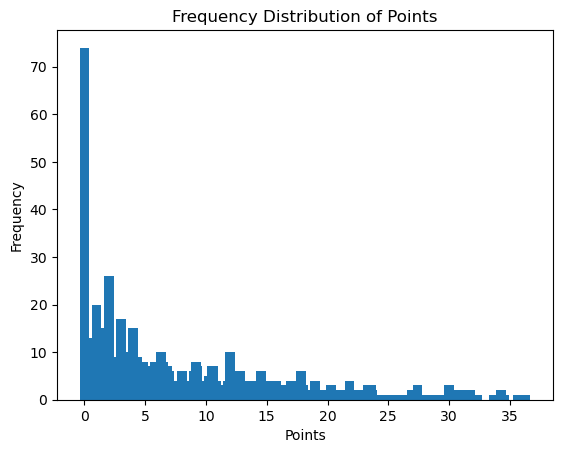

In [31]:
plt.bar(points_freq.index, points_freq.values)
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Points')
plt.show()

# Correlation Analysis

### FG%

In [27]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['FG%'] = pd.to_numeric(df['FG%'], errors='coerce')

fg_correlation = df.groupby('Year')['FG%'].corr(df['Year'])
fg_correlation

Year
2020.0    0.000000e+00
2021.0    2.529016e-03
2022.0    4.659227e-19
2023.0    5.813414e-19
Name: FG%, dtype: float64

In [ ]:
# need to spend some time reviewing pearson correlation coefficients to truly analyze this

# Improving Z Scores

https://github.com/zer2/Fantasy-Basketball--in-progress-

# Data Cleaning

In [ ]:
import pandas as pd
import numpy as np

# create variables for scoring settings
global pointsScored, totalRebounds, assists, steals, blockedShots, turnovers
pointsScored = 1.0
totalRebounds = 1.2
assists = 1.5
steals = 3.0
blockedShots = 3.0
turnovers = -1.0

In [ ]:
# load Master_topPicks into dataframe
df = pd.read_csv("topPicksCSV/Playoffs-Master_topPicks.csv")

# keep only the columns we need
stats_to_keep = [
    "Player",
    "Pos",
    "Tm",
    "G",
    "MP",
    "TRB",
    "AST",
    "STL",
    "BLK",
    "TOV",
    "PTS",
    "Year",
]
df = df[stats_to_keep]

# capture each player occurences
# df = df.groupby(["Player"]).sum().reset_index()

# if a player has played for multiple years, average their stats across those years
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
df = df.groupby(["Player"])[numeric_cols].mean().reset_index()

# drop year column
df = df.drop("Year", axis=1)

In [ ]:
# create calculated column for fantasy points
df["FantasyPoints"] = (
    df["PTS"] * pointsScored
    + df["TRB"] * totalRebounds
    + df["AST"] * assists
    + df["STL"] * steals
    + df["BLK"] * blockedShots
    + df["TOV"] * turnovers)

#round to the nearest decimal
df = df.round(1)

In [ ]:
# write to csv
df.to_csv("topPicksCSV/Playoffs-Master-Combined_topPicks.csv", index=False)

df